# 1st Model

## 1. Libraries

In [70]:
# Importing libraries
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import tqdm
from tqdm.auto import tqdm

## 2. Manual Seed

In [71]:
# Define the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 3. Agnostic code

In [72]:
# Make a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The device is: {device}")
n_gpus = torch.cuda.device_count()
print(f"Number of gpus: {n_gpus}")
!nvidia-smi --query-gpu=name --format=csv,noheader

The device is: cuda
Number of gpus: 1
NVIDIA GeForce RTX 2060


## 4. Resize the data

In [73]:
# Define the transformations we will apply to images
# they need to match the size of images the architecture was developed for

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

## 5. Define the dataset

In [74]:
dataset = torchvision.datasets.ImageFolder(
    'D:/Cinthia/env_modelos/tiny-imagenet-200/tiny-imagenet-200/train',
    transform=transform
)

## 6. Split the data

In [75]:
# Split the data
train_data , val_data , test_data = torch.utils.data.random_split(
    dataset, [80000,10000,10000]
)

## 7. Creating DataLoaders

In [76]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4*n_gpus)

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=4*n_gpus)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4*n_gpus)

## 8. Visualize!

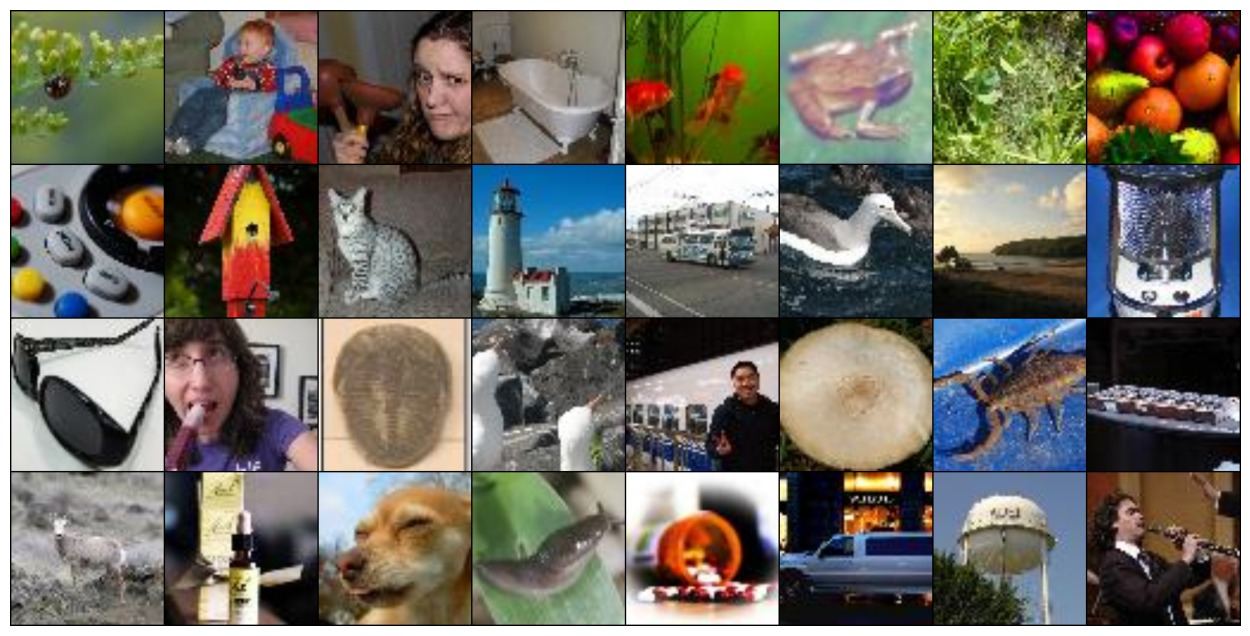

In [77]:
for images, _ in train_dataloader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1,2,0)))
    break

## 9. Building the blocks

### 1. Conv block

In [78]:
class ConvBlock (nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 **kwargs): # this means that the key arguments are arbitrary
        super().__init__()

        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              **kwargs,
                              device=device)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels) # to improve performance
    
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

### 2. Inception block

In [79]:
class InceptionBlock (nn.Module):
    def __init__(self,
                 
                 in_channels: int,
                 out_1x1: int,

                 red_3x3: int,
                 out_3x3: int,

                 red_5x5: int,
                 out_5x5: int,

                 out_1x1pool: int):
        
        super().__init__()

        self.branch1 = ConvBlock(in_channels=in_channels,
                                 out_channels=out_1x1,
                                 kernel_size=1)
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels=in_channels,
                      out_channels=red_3x3,
                      kernel_size=1),
            ConvBlock(in_channels=red_3x3,
                      out_channels=out_3x3,
                      kernel_size=3,
                      padding=1) # ojo (btw no ponemos el S bc por defecto es 1)
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels=in_channels,
                      out_channels=red_5x5,
                      kernel_size=1),
            ConvBlock(in_channels=red_5x5,
                      out_channels=out_5x5,
                      kernel_size=5,
                      padding=2) # ojo (btw no ponemos el S bc por defecto es 1)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            ConvBlock(in_channels=in_channels,
                      out_channels=out_1x1pool,
                      kernel_size=1)
        )

    def forward(self,x):
        # N x filters x 28 x 28 → 0th x 1st x 2nd x 3rd dimension (we use 1)
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],1)

### 3. Auxiliary

**Auxilary classifier (yellow)**

Only during training

We want to improve the regularization of the network

We are trying to make sure that the layers up until this point do something useful

Reduce the avility of the network overfit

In [110]:
class Auxiliary (nn.Module):
    def __init__(self,
                 in_channels: int,
                 num_classes: int):
        super().__init__()

        self.aux1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=5,stride=3),
            ConvBlock(in_channels=in_channels,
                      out_channels=128, # xq 128?
                      kernel_size=1),
            nn.ReLU(),
        )
        
        self.aux2 = nn.Sequential(
            # in_features=2048 because we should flatten the input tensor which has shape of (batch, 4,4,128) so after flaten the tensor will be (batch, 4*4*128)
            # out_features=1024 this number from paper
            nn.Linear(in_features=4*4*128,out_features=1024),
            nn.Dropout(0.7),
            nn.Linear(1024,num_classes)
        )

    def forward(self,x):
        x = self.aux1(x)
        x = x.view(x.shape[0],-1) # instead of reshape or flatten
        x = self.aux2(x)
        return x

## 10. GoogleNet

In [112]:
class GoogleNet(nn.Module):
    def __init__(self,
                 in_channels=3,
                 use_auxiliary=True,
                 num_classes=1000 # let's put 1k
                 ):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels=in_channels,
                               out_channels=64,
                               kernel_size=7,
                               stride=2,
                               padding=3)
        self.conv2 = ConvBlock(in_channels=64,
                               out_channels=192,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.avgpool = nn.AvgPool2d(kernel_size=7,stride=1)

        self.dropout = nn.Dropout(0.4)

        self.linear = nn.Linear(1024,num_classes)

        # In this order: in_channels,out_1x1,red_3x3,out_3x3,red_5x5,out_5x5,out_1x1pool
        # Use the table

        self.inception3a = InceptionBlock(192, 64, 96,128, 16, 32, 32)
        self.inception3b = InceptionBlock(256,128,128,192, 32, 96, 64)

        self.inception4a = InceptionBlock(480,192, 96,208, 16, 48, 64)
        self.inception4b = InceptionBlock(512,160,112,224, 24, 64, 64)
        self.inception4c = InceptionBlock(512,128,128,256, 24, 64, 64)
        self.inception4d = InceptionBlock(512,112,144,288, 32, 64, 64)
        self.inception4e = InceptionBlock(528,256,160,320, 32,128,128)

        self.inception5a = InceptionBlock(832,256,160,320,32,128,128)
        self.inception5b = InceptionBlock(832,384,192,384,48,128,128)
        
        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.aux4a = Auxiliary(512,num_classes=num_classes)
            self.aux4d = Auxiliary(528,num_classes=num_classes)

    def forward(self,x):
        y = None # this is for the Aux classifier
        z = None # this is for the Aux classifier

        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.aux4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.aux4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1) # instead of reshape or flatten
        x = self.dropout(x)
        x = self.linear(x)
        
        return x,y,z

## 11. Setup

In [113]:
model_0 = GoogleNet().to(device)
print(f"Are the models in the 'cuda' device? {next(model_0.parameters()).is_cuda}")

Are the models in the 'cuda' device? True


In [114]:
model_0.state_dict()

OrderedDict([('conv1.conv.weight',
              tensor([[[[ 3.9372e-02, -1.3478e-03, -3.0274e-02,  ..., -6.8948e-02,
                         -5.8768e-02, -2.1217e-03],
                        [ 1.1699e-02, -7.5871e-03, -4.1468e-02,  ..., -1.8676e-03,
                          3.3925e-02,  5.7487e-02],
                        [-5.8071e-02, -2.7645e-02, -5.3275e-02,  ...,  4.9288e-02,
                         -3.5436e-02, -3.1929e-02],
                        ...,
                        [-7.6761e-02, -4.4831e-02,  7.6937e-02,  ..., -1.3084e-03,
                          7.9848e-02, -2.8629e-02],
                        [-5.4736e-02, -4.6887e-03, -6.5083e-02,  ...,  1.2174e-02,
                         -2.4001e-02,  6.1028e-02],
                        [-4.8085e-03,  5.2477e-02,  1.1404e-02,  ..., -2.8613e-02,
                         -5.4846e-02, -5.2272e-02]],
              
                       [[ 7.4886e-02, -3.4356e-02,  9.5101e-04,  ..., -6.4852e-02,
                         -1

## 12. Setup loss, optimizer and evaluation metrics

### 0. Download helper functions

In [115]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


### 1. Default functions

In [116]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_0.parameters(),
                       lr = 0.001,
                       weight_decay=1e-3)

# Smth new!
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                    patience=5)
# current_lrs = lr_scheduler.get_last_lr() ← use it like this

### 2. Function to time our experiments

In [117]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Print diff between start and end time:"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [118]:
# An example
start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


7.199999527074397e-05

### 3. Creating a training loop and trainig the model on batches of data

In [120]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):
    
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    if phase == 'train': # Backward + optimize only if in training phase
                        if use_auxiliary:
                            outputs, aux1, aux2 = model(inputs)
                            loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                        else:
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)
                            
                        _, preds = torch.max(outputs, 1)
                        loss.backward()
                        optimizer.step()
                    
                    if phase == 'val':
                        outputs, _, _ = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)


                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## 13. Prediction results

In [121]:
model, _ = train_model(model_0, {"train": train_dataloader, "val": val_dataloader}, loss_fn, optimizer, 3)

Epoch 0/2
----------
train Loss: 7.7768 Acc: 0.0423
val Loss: 4.4607 Acc: 0.0737

Epoch 1/2
----------
train Loss: 6.6529 Acc: 0.1080
val Loss: 4.0110 Acc: 0.1264

Epoch 2/2
----------
train Loss: 6.1977 Acc: 0.1526
val Loss: 3.8239 Acc: 0.1636

Training complete in 35m 43s
Best val Acc: 0.163600


# From FaceNet

In [ ]:
class InceptionBlock (nn.Module):
    def __init__(self,
                 
                 in_channels: int,
                 out_1x1: int,

                 red_3x3: int,
                 out_3x3: int,

                 red_5x5: int,
                 out_5x5: int,

                 out_1x1pool: int):
        
        super().__init__()

        self.branch1 = ConvBlock(in_channels=in_channels,
                                 out_channels=out_1x1,
                                 kernel_size=1)
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels=in_channels,
                      out_channels=red_3x3,
                      kernel_size=1),
            ConvBlock(in_channels=red_3x3,
                      out_channels=out_3x3,
                      kernel_size=3,
                      padding=1) # ojo (btw no ponemos el S bc por defecto es 1)
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels=in_channels,
                      out_channels=red_5x5,
                      kernel_size=1),
            ConvBlock(in_channels=red_5x5,
                      out_channels=out_5x5,
                      kernel_size=5,
                      padding=2) # ojo (btw no ponemos el S bc por defecto es 1)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            ConvBlock(in_channels=in_channels,
                      out_channels=out_1x1pool,
                      kernel_size=1)
        )

    def forward(self,x):
        # N x filters x 28 x 28 → 0th x 1st x 2nd x 3rd dimension (we use 1)
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],1)